# Imports

### Libraries

In [28]:
import time
import h5py
import numpy as np

import torch
import torchvision
import onnx

from torch import nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

### Device

In [2]:
torch.cuda.is_available()

True

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

### Path

In [4]:
path_full_model = "../models/full_model.pt"
path_converted_model = "../models/full_model.onnx"

path_dataset = "../datasets/dataset.h5py"

### Dataset

In [5]:
h5f = h5py.File(path_dataset, 'r')

X_train = np.array(h5f['X_train'])
X_test = np.array(h5f['X_test'])
y_train = np.array(h5f['y_train'])
y_test = np.array(h5f['y_test'])

In [6]:
X_train = X_train.astype(np.float32)
X_test = X_test.astype(np.float32)

# Model loading

### Architecture

In [7]:
class CNN(nn.Module):

    def __init__(self):
        super(CNN, self).__init__()

        # Features detector
        self.features1 = nn.Sequential(
            
            # Hidden layer 1
            nn.Conv2d(3, 16, kernel_size=3), nn.ReLU(),
            nn.BatchNorm2d(16),

            nn.MaxPool2d((2, 2)),
            nn.Dropout(0.35)
        )

        # Features detector
        self.features2 = nn.Sequential(
            
            # Hidden layer 3
            nn.Conv2d(16, 32, kernel_size=3), nn.ReLU(),
            nn.BatchNorm2d(32),

            nn.MaxPool2d((2, 2)),
            nn.Dropout(0.35)
        )

        # Features detector
        self.features3 = nn.Sequential(
            
            # Hidden layer 3
            nn.Conv2d(32, 64, kernel_size=3), nn.ReLU(),
            nn.BatchNorm2d(64),

            nn.MaxPool2d((2, 2)),
            nn.Dropout(0.35)
        )

        # Classifier
        self.classifier = nn.Sequential(
            
            nn.Linear(64*13*13, 512), nn.ReLU(),
            nn.BatchNorm1d(512),
            nn.Dropout(0.50),

            # Output layer
            nn.Linear(512, 108)
        )

    def forward(self, X):

        # Features
        X = self.features1(X)
        X = self.features2(X)
        X = self.features3(X)

        # print(X.shape)

        # Classifier
        X = X.view(-1, 64*13*13)
        #X = X.view(X.size(0), -1)
        X = self.classifier(X)

        return F.log_softmax(X, dim=1)

### Model

In [8]:
model = torch.load(path_full_model)
model.eval()

CNN(
  (features1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (4): Dropout(p=0.35, inplace=False)
  )
  (features2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (4): Dropout(p=0.35, inplace=False)
  )
  (features3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (4): Dropout(p=0.35, inplace=False)
  )
  (classi

# Model evaluation

### Preprocess dataset

Specific preprocessing has to be applied for PyTorch model

In [9]:
X_test.shape

(755, 3, 120, 120)

In [10]:
X_test_tensor = torch.tensor(np.array([np.expand_dims(image, 0) for image in X_test]), device=device)
X_test_tensor.shape

torch.Size([755, 1, 3, 120, 120])

### Inference

In [12]:
results = []
t1 = time.time()

for image in X_test_tensor:
    results.append(model(image).detach())

cost_time = time.time() - t1

### Inference time

Inference time: **0.6166** sec, for **755** images.

Time per image: **0.008 sec**/image

In [15]:
len(results)

755

In [16]:
print("cost time: ", cost_time)

cost time:  0.6166174411773682


In [17]:
print("time per image: ", cost_time / len(results))

time per image:  0.0008167118426190307


### Score

In [26]:
results_np = np.array([entry.cpu().numpy() for entry in results]).squeeze()
prediction = results_np.argmax(axis=1)

<AxesSubplot:>

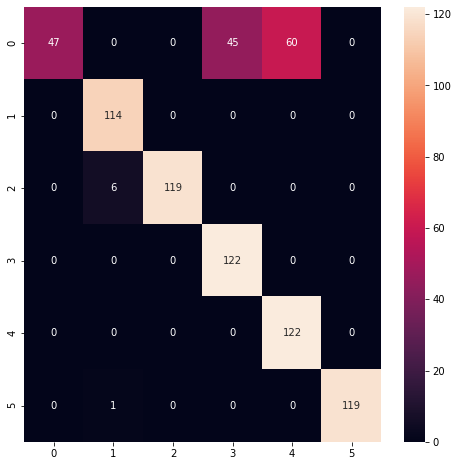

In [29]:
conf_matrix = confusion_matrix(y_test, prediction)

plt.figure(figsize=(8, 8))
sns.heatmap(conf_matrix, annot=True, fmt='g')